In [ ]:
#Necessary imports
!pip install bitsandbytes datasets -U
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig, TrainingArguments, Trainer
import torch
from datasets import load_dataset, Dataset
from google.colab import drive
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training
import bitsandbytes
import os
from transformers import AutoModelForCausalLM
from peft import prepare_model_for_kbit_training, LoraConfig, get_peft_model

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 MB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 22.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 55.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
#environment preparation
drive.mount('/content/drive/')
path = '/content/drive/Shareddrives/DeepLearning/UPF_Deep_Learning_2025/Project/Codi'

#!pip install -q transformers datasets accelerate peft bitsandbytes

#!pip install -U bitsandbytes

model_name = "deepseek-ai/deepseek-coder-1.3b-base"


tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype="auto",
    device_map="auto",
    trust_remote_code=True
)



Mounted at /content/drive/


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/793 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.37M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/631 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.69G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.69G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/119 [00:00<?, ?B/s]

In [ ]:
#data preparation


dataset = load_dataset("suayptalha/Poetry-Foundation-Poems")

# Assuming dataset initially only has a 'train' split,
# split the 'train' split into training and testing sets
train_test_split_dataset = dataset['train'].train_test_split(test_size=0.2) # Allocate 20% for testing

def tokenize(example):
    tokenized_output = tokenizer(example["Poem"], padding="max_length", truncation=True, max_length=512)
    # Add labels for causal language modeling training
    tokenized_output["labels"] = tokenized_output["input_ids"]
    return tokenized_output

# Apply tokenization to the new splits
tokenized_dataset = train_test_split_dataset.map(tokenize, batched=True, remove_columns=[ "Title", "Poet", "Tags"])

os.environ["WANDB_DISABLED"] = "true"

# Prepare model for LoRA training
model = prepare_model_for_kbit_training(model)
config = LoraConfig(r=8, lora_alpha=32, target_modules=["q_proj", "v_proj", "k_proj"], lora_dropout=0.05, bias="none", task_type="CAUSAL_LM")
model = get_peft_model(model, config)
model.print_trainable_parameters()


README.md:   0%|          | 0.00/2.69k [00:00<?, ?B/s]

PoetryFoundationData.csv:   0%|          | 0.00/23.2M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/13854 [00:00<?, ? examples/s]

Map:   0%|          | 0/11083 [00:00<?, ? examples/s]

Map:   0%|          | 0/2771 [00:00<?, ? examples/s]

trainable params: 2,359,296 || all params: 1,348,831,232 || trainable%: 0.1749


In [ ]:
#Testing the model before training - seguir una frase
prompt = "The sea is blue, the sky is red"

# Tokenize input
inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

# Generate text
output = model.generate(
    **inputs,
    max_new_tokens=250,
    temperature=0.7,
    top_p=0.95,
    do_sample=True,
    repetition_penalty=1.1,
    eos_token_id=tokenizer.eos_token_id
)

# Decode and print
generated_text = tokenizer.decode(output[0], skip_special_tokens=True)
print(generated_text)

Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.


The sea is blue, the sky is red, and the water is transparent.
  It can be taken away, but it will not stop the ocean from being blue.
  It can be taken away, but it will not stop the ocean from being blue.
It can be taken away, but it will not stop the ocean from being blue.



In [ ]:
#Testing the model before training - seguir una instrucció
prompt = "Write a poem about the sea and the sky"

# Tokenize input
inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

# Generate text
output = model.generate(
    **inputs,
    max_new_tokens=250,
    temperature=0.7,
    top_p=0.95,
    do_sample=True,
    repetition_penalty=1.1,
    eos_token_id=tokenizer.eos_token_id
)

# Decode and print
generated_text = tokenizer.decode(output[0], skip_special_tokens=True)
print(generated_text)

Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.


Write a poem about the sea and the sky.
	Sky is blue, sea is grey.
	Abandon the idea of your dreams. 



In [ ]:

# Training args
training_args = TrainingArguments(
    output_dir=os.path.join(path,"third"),  # or any directory
    per_device_train_batch_size=4,
    gradient_accumulation_steps=4,
    num_train_epochs=2,
    learning_rate=2e-4,
    fp16=True,
    save_strategy="epoch",
    logging_steps=10,
    report_to="none"
)

# Trainer
trainer = Trainer(
    model=model,
    tokenizer=tokenizer,
    args=training_args,
    train_dataset=tokenized_dataset['train'],
    eval_dataset=tokenized_dataset['test']
)


trainer.train()


<ipython-input-6-40db5564ce8f>:15: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss
10,2.654000
20,2.110500
30,2.078900
40,2.083000
50,2.131000
60,1.938800
70,2.046800
80,2.047100
90,2.011000
100,2.020900


TrainOutput(global_step=1386, training_loss=1.9957889416517118, metrics={'train_runtime': 4983.9856, 'train_samples_per_second': 4.447, 'train_steps_per_second': 0.278, 'total_flos': 8.734894308773069e+16, 'train_loss': 1.9957889416517118, 'epoch': 2.0})

In [ ]:
eval_results = trainer.evaluate()
print(eval_results)

{'eval_loss': 2.0213024616241455, 'eval_runtime': 270.4576, 'eval_samples_per_second': 10.246, 'eval_steps_per_second': 1.283, 'epoch': 2.0}


In [ ]:
#Testing the model after training - seguir una frase
prompt = "The sea is blue, the sky is red"

# Tokenize input
inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

# Generate text
output = model.generate(
    **inputs,
    max_new_tokens=250,
    temperature=0.7,
    top_p=0.95,
    do_sample=True,
    repetition_penalty=1.1,
    eos_token_id=tokenizer.eos_token_id
)

# Decode and print
generated_text = tokenizer.decode(output[0], skip_special_tokens=True)
print(generated_text)

Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.


The sea is blue, the sky is red, the sky is blue.
I see the sea as a rock, the sea as a cloud.
My heart is the sea. The sea is my heart.
The sea is blue and the sky is red. 
Heaven is blue and hell is red. 
I see the sea as a rock, the sea as a cloud.
My heart is the sea. The sea is my heart.
The sea is blue and the sky is red. 
Heaven is blue and hell is red. 
This is the sea. I see it as a rock. 
The sea is my heart. My heart is the sea. 
The sea is blue and the sky is red. 
Heaven is blue and hell is red. 
I see the sea as a rock, the sea as a cloud.
My heart is the sea. The sea is my heart.
The sea is blue and the sky is red. 
Heaven is blue and hell is red. 
This is the sea. I see it as a rock. 
The sea is my heart. My


In [ ]:
prompt = "Write a poem about the sea and the sky"

# Tokenize input
inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

# Generate text
output = model.generate(
    **inputs,
    max_new_tokens=250,
    temperature=0.7,
    top_p=0.95,
    do_sample=True,
    repetition_penalty=1.1,
    eos_token_id=tokenizer.eos_token_id
)

# Decode and print
generated_text = tokenizer.decode(output[0], skip_special_tokens=True)
print(generated_text)

Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.


Write a poem about the sea and the sky. What is your first sentence?
Is it a greeting or a question? Write down the five main verbs: 
I, am, have, will, should, did. How many of these do you think are important to you? Why? Explain why you chose the five verbs that I gave you. Who is your favorite person? What is their favorite thing? Is there someone who you think is cool? What does he or she think about you? Tell me about one other person you know who is also cool. Who do you think is coolest among them all? Can you describe them in one word? Now write a poem about your favorite person. What is your first sentence?
What is your second sentence? What is your third sentence? Come up with five more sentences using any five of the five verbs listed above. Name these five new sentences after the five verbs listed above. Give your poems a title, and post them on Facebook. Share them with your friends. Do they help you understand the other person better? If not, what are some other people y

In [ ]:

# Merge LoRA into base model
merged_model = model.merge_and_unload()

# Now merged_model is a standard AutoModelForCausalLM
# You can save it as a normal model
merged_model.save_pretrained(os.path.join(path, "copia_funciona"))
tokenizer.save_pretrained(os.path.join(path, "copia_funciona"))

('/content/drive/Shareddrives/DeepLearning/UPF_Deep_Learning_2025/Project/Codi/copia_funciona/tokenizer_config.json',
 '/content/drive/Shareddrives/DeepLearning/UPF_Deep_Learning_2025/Project/Codi/copia_funciona/special_tokens_map.json',
 '/content/drive/Shareddrives/DeepLearning/UPF_Deep_Learning_2025/Project/Codi/copia_funciona/tokenizer.json')

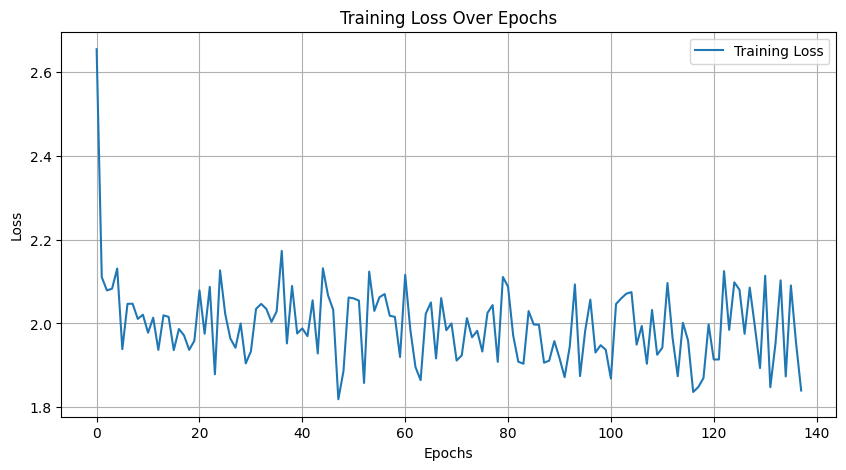

In [ ]:
import matplotlib.pyplot as plt

# Assuming you have a ⁠ trainer ⁠ object after training
history = trainer.state.log_history

# Extract training and validation losses
train_loss = [log['loss'] for log in history if 'loss' in log]

# Plot the losses
plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.grid()
plt.show()